# Importy, wizualizacja
(Należy odpalić i schować).

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor

%matplotlib inline


def plot_dataset(train_data, model):
    # view_data = train_data.data[:5].view(-1, 28 * 28) / 255.0
    # _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().cuda() / 255.0)
    # decoded_data = decoded_data.cpu().detach().numpy()

    device = next(model.parameters()).device

    view_data = train_data.data[:5].view(-1, 28 * 28).to(device) / 255.0
    _, decoded_data = model.forward(view_data.float())
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap="gray")
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[i].set_xticks(())
            axes[i].set_yticks(())

    plt.show()


def plot_pca(data, model):

    device = next(model.parameters()).device
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    # z = model.encode(train_data.data.view(-1, 784).float().cuda())
    # reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    z = model.encode(data.data.view(-1, 784).float().to(device))
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = data.targets == class_idx
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1], s=2.0, label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(
    root=".", train=True, transform=transforms, download=True
)  # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2023-24/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x 
$$
$$
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim) 
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
        
    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)
    
    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def forward(self, x: torch.Tensor):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0507


<Figure size 640x480 with 0 Axes>

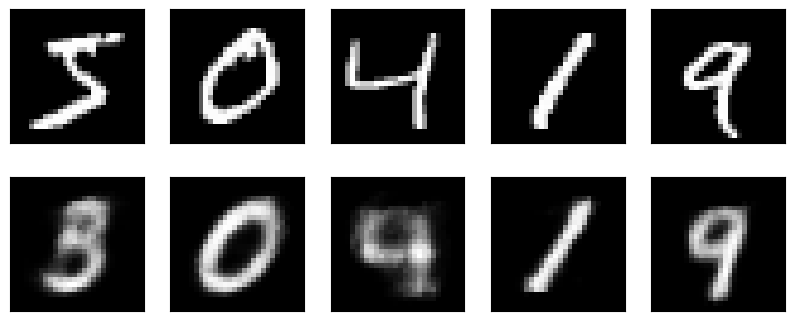

<Figure size 640x480 with 0 Axes>

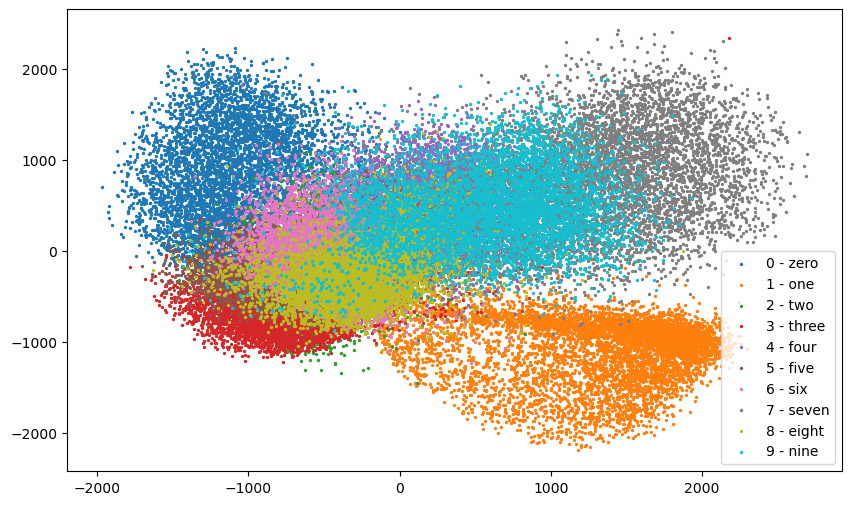

Epoch: 1  |  train loss: 0.0300
Epoch: 2  |  train loss: 0.0246
Epoch: 3  |  train loss: 0.0216
Epoch: 4  |  train loss: 0.0199
Epoch: 5  |  train loss: 0.0187
Epoch: 6  |  train loss: 0.0180
Epoch: 7  |  train loss: 0.0175
Epoch: 8  |  train loss: 0.0171
Epoch: 9  |  train loss: 0.0168
Epoch: 10  |  train loss: 0.0166


<Figure size 640x480 with 0 Axes>

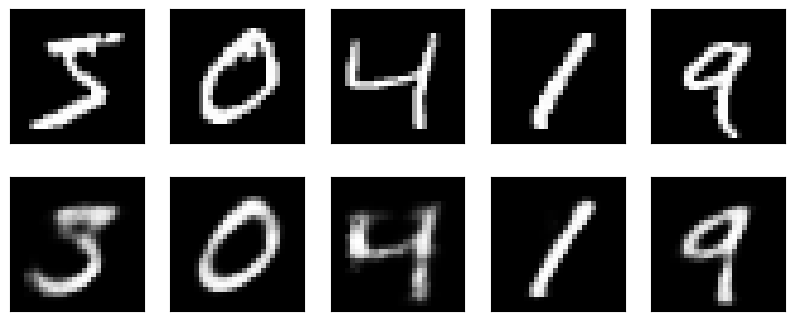

<Figure size 640x480 with 0 Axes>

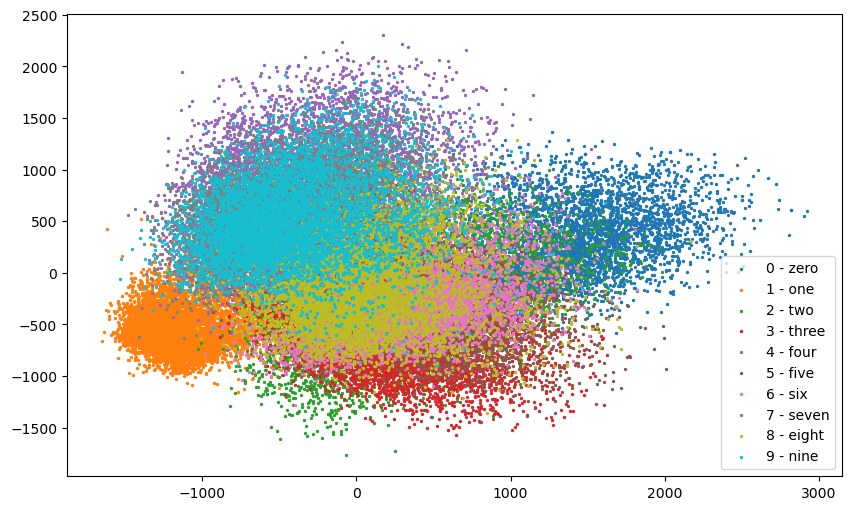

Epoch: 11  |  train loss: 0.0164
Epoch: 12  |  train loss: 0.0162
Epoch: 13  |  train loss: 0.0161
Epoch: 14  |  train loss: 0.0160
Epoch: 15  |  train loss: 0.0158
Epoch: 16  |  train loss: 0.0158
Epoch: 17  |  train loss: 0.0157
Epoch: 18  |  train loss: 0.0156
Epoch: 19  |  train loss: 0.0155
Epoch: 20  |  train loss: 0.0155


<Figure size 640x480 with 0 Axes>

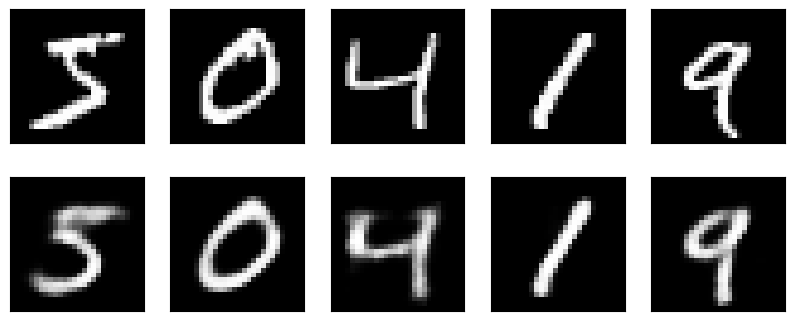

<Figure size 640x480 with 0 Axes>

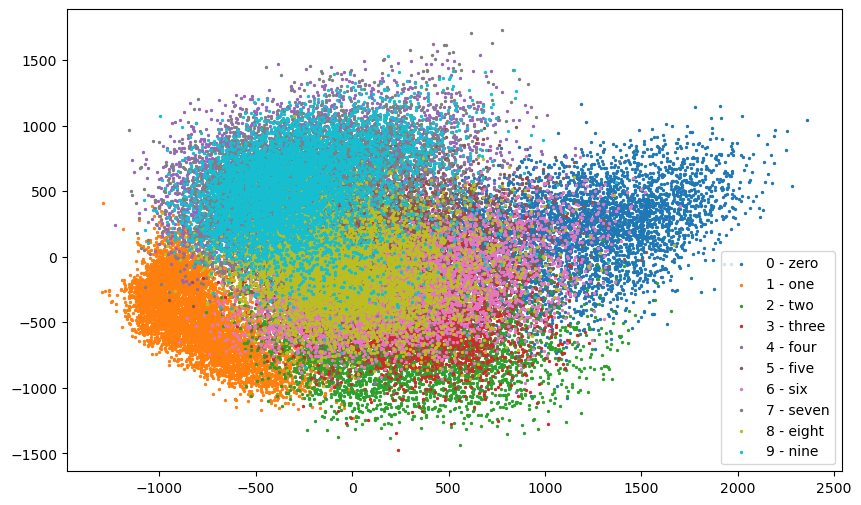

Epoch: 21  |  train loss: 0.0154
Epoch: 22  |  train loss: 0.0153
Epoch: 23  |  train loss: 0.0153
Epoch: 24  |  train loss: 0.0152


In [10]:
# Hyper Parameters
epochs: int = 25
LR: float = 5e-3  # learning rate

# prepare original data for plotting

# autoencoder = AutoEncoder(latent_dim=10).cuda()
autoencoder = AutoEncoder(latent_dim=10)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        # x = x.cuda()
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x)  # calculate loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        epoch_losses.append(loss_val.item())

    print(f"Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}")

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [11]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(
    root=".", train=False, transform=transforms, download=True
)  # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [12]:
### Tutaj zaimplementuj i wytrenuj model baseline'owy

class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # 10 klas dla MNIST
        )
        
    def forward(self, x):
        return self.network(x)

In [16]:
### Tutaj zaimplementuj i wytrenuj klasyfikator oparty o reprezentację podaną przez autoenkoder.

device = torch.device('cpu') 

baseline_model = SimpleClassifier().to(device)

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    baseline_model.train()
    epoch_losses = []
    for x, y in labeled_loader:
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = baseline_model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}')

baseline_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.view(-1, 28*28).to(device)
        y_test = y_test.to(device)
        outputs = baseline_model(x_test)
        _, predicted = torch.max(outputs.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()
print(f'Accuracy of the baseline model on the test images: {100 * correct / total:.2f}%')



Epoch 1, Loss: 2.2868
Epoch 2, Loss: 2.1470
Epoch 3, Loss: 2.0236
Epoch 4, Loss: 1.9160
Epoch 5, Loss: 1.8137
Epoch 6, Loss: 1.5458
Epoch 7, Loss: 1.4350
Epoch 8, Loss: 1.1510
Epoch 9, Loss: 1.0340
Epoch 10, Loss: 0.8092
Epoch 11, Loss: 0.6629
Epoch 12, Loss: 0.6704
Epoch 13, Loss: 0.4324
Epoch 14, Loss: 0.3978
Epoch 15, Loss: 0.3428
Epoch 16, Loss: 0.2691
Epoch 17, Loss: 0.1966
Epoch 18, Loss: 0.3027
Epoch 19, Loss: 0.1796
Epoch 20, Loss: 0.1307
Epoch 21, Loss: 0.1070
Epoch 22, Loss: 0.0900
Epoch 23, Loss: 0.0646
Epoch 24, Loss: 0.0518
Epoch 25, Loss: 0.0445
Epoch 26, Loss: 0.0538
Epoch 27, Loss: 0.0477
Epoch 28, Loss: 0.0402
Epoch 29, Loss: 0.0362
Epoch 30, Loss: 0.0253
Epoch 31, Loss: 0.0246
Epoch 32, Loss: 0.0256
Epoch 33, Loss: 0.0213
Epoch 34, Loss: 0.0205
Epoch 35, Loss: 0.0168
Epoch 36, Loss: 0.0155
Epoch 37, Loss: 0.0152
Epoch 38, Loss: 0.0128
Epoch 39, Loss: 0.0147
Epoch 40, Loss: 0.0111
Epoch 41, Loss: 0.0148
Epoch 42, Loss: 0.0115
Epoch 43, Loss: 0.0094
Epoch 44, Loss: 0.01

## Dygresja: Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?
* [Przegląd metod kontrastywnych](https://arxiv.org/abs/2011.00362) - Czy możemy się uczyć reprezentacji na podstawie szukania podobieństw między przykładami?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

100%|██████████| 26421880/26421880 [00:13<00:00, 1980504.89it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 69179.29it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2112025.39it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5790366.58it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



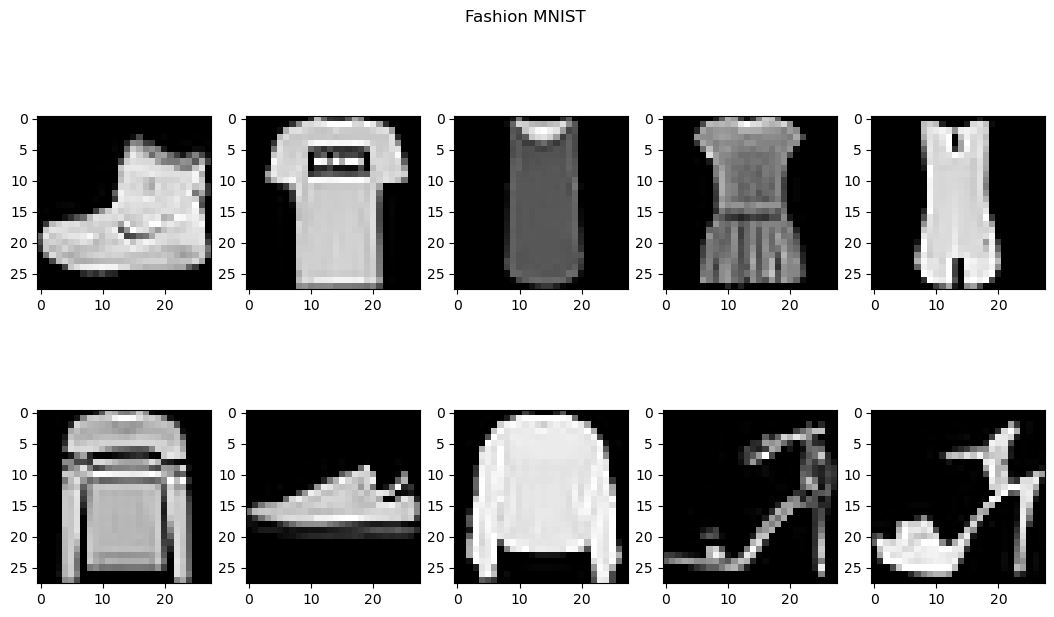

In [17]:
# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root=".", train=True, transform=transforms, download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap="gray")
plt.suptitle("Fashion MNIST")
plt.show()


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [19]:
class WAEMMD(nn.Module):
    def __init__(self, latent_dim: int):
        super(WAEMMD, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid() 
        )

    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)
        
    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def forward(self, x: torch.Tensor):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

    def mmd_loss(self, z: torch.Tensor, sigma: float):
        z_prior = torch.randn_like(z)
        x_kernel = self.compute_kernel(z, z, sigma)
        y_kernel = self.compute_kernel(z_prior, z_prior, sigma)
        xy_kernel = self.compute_kernel(z, z_prior, sigma)
        mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
        return mmd

    def compute_kernel(self, x, y, sigma):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1)  # (batch_size, 1, latent_dim)
        y = y.unsqueeze(0)  # (1, batch_size, latent_dim)
        x = x.expand(x_size, y_size, dim)
        y = y.expand(x_size, y_size, dim)
        kernel_input = ((x - y) ** 2).sum(2) / (2 * sigma ** 2)
        return torch.exp(-kernel_input)

Epoch 1, Loss: 0.0514


<Figure size 640x480 with 0 Axes>

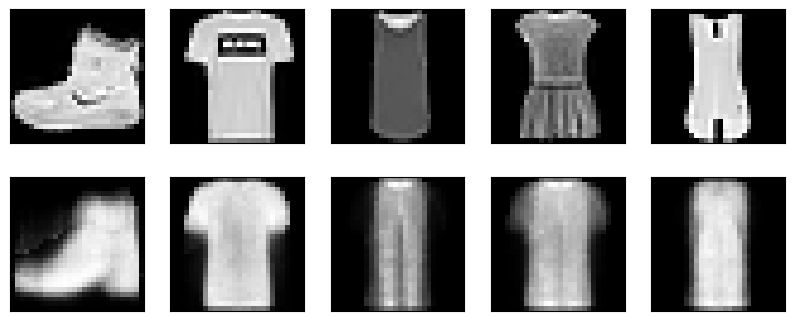

<Figure size 640x480 with 0 Axes>

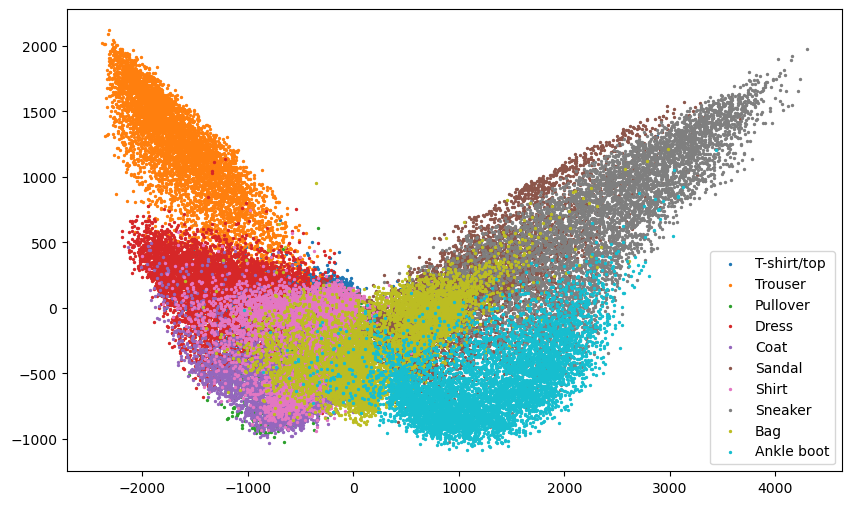

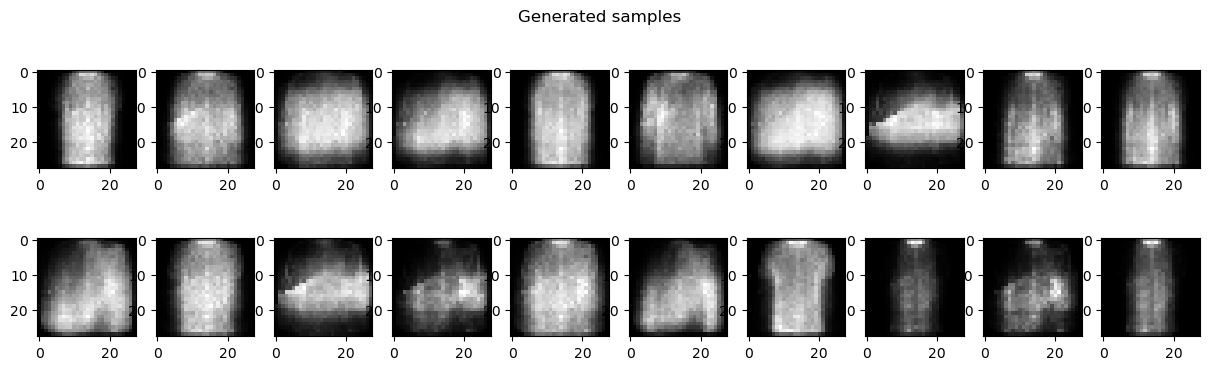

Epoch 2, Loss: 0.0259
Epoch 3, Loss: 0.0223
Epoch 4, Loss: 0.0204
Epoch 5, Loss: 0.0189
Epoch 6, Loss: 0.0178
Epoch 7, Loss: 0.0168
Epoch 8, Loss: 0.0160
Epoch 9, Loss: 0.0153
Epoch 10, Loss: 0.0149
Epoch 11, Loss: 0.0144


<Figure size 640x480 with 0 Axes>

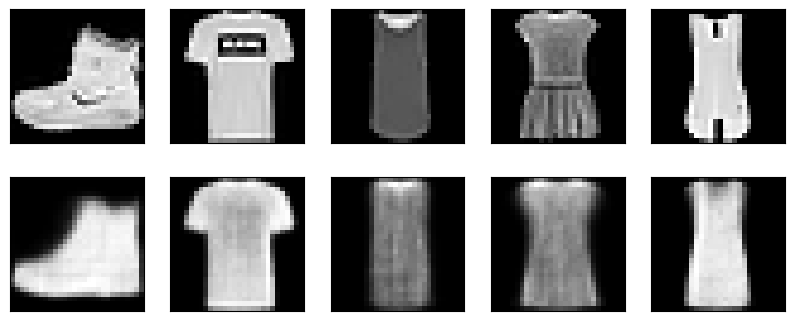

<Figure size 640x480 with 0 Axes>

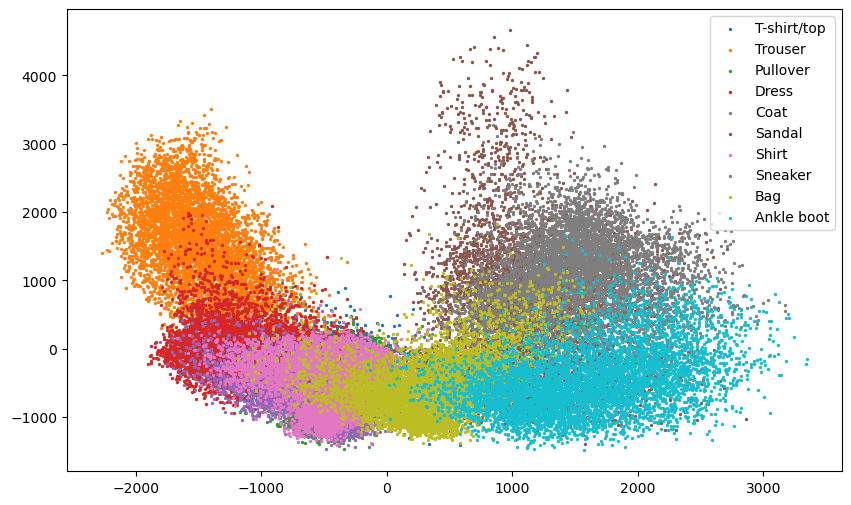

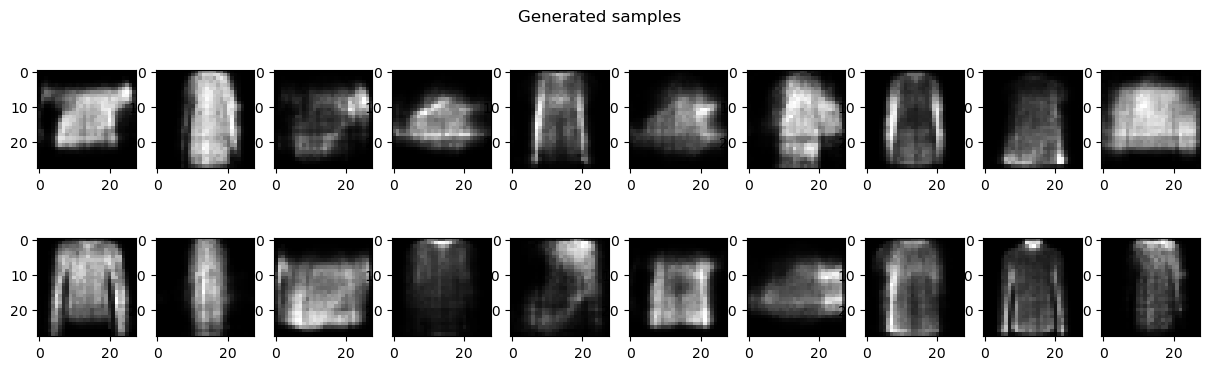

Epoch 12, Loss: 0.0140
Epoch 13, Loss: 0.0137
Epoch 14, Loss: 0.0135
Epoch 15, Loss: 0.0132
Epoch 16, Loss: 0.0130
Epoch 17, Loss: 0.0126
Epoch 18, Loss: 0.0124
Epoch 19, Loss: 0.0122
Epoch 20, Loss: 0.0120
Epoch 21, Loss: 0.0118


<Figure size 640x480 with 0 Axes>

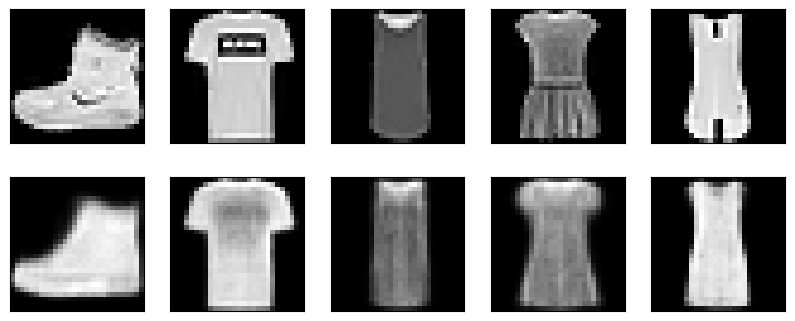

<Figure size 640x480 with 0 Axes>

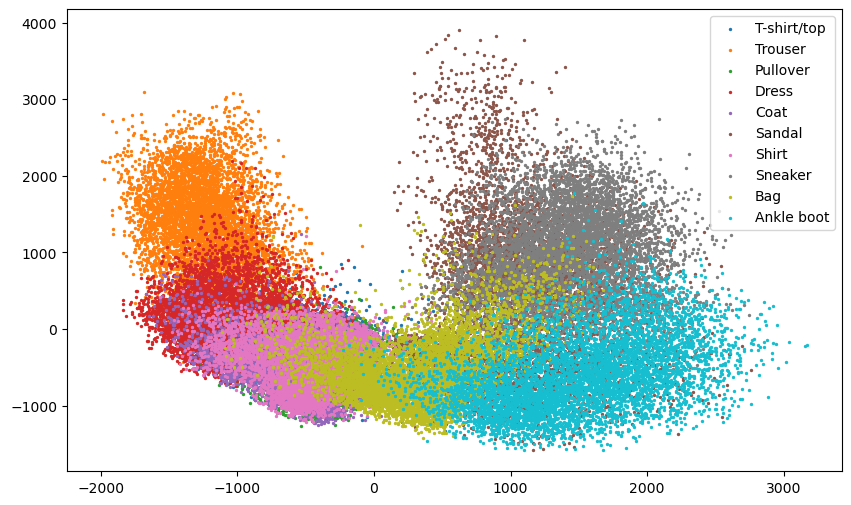

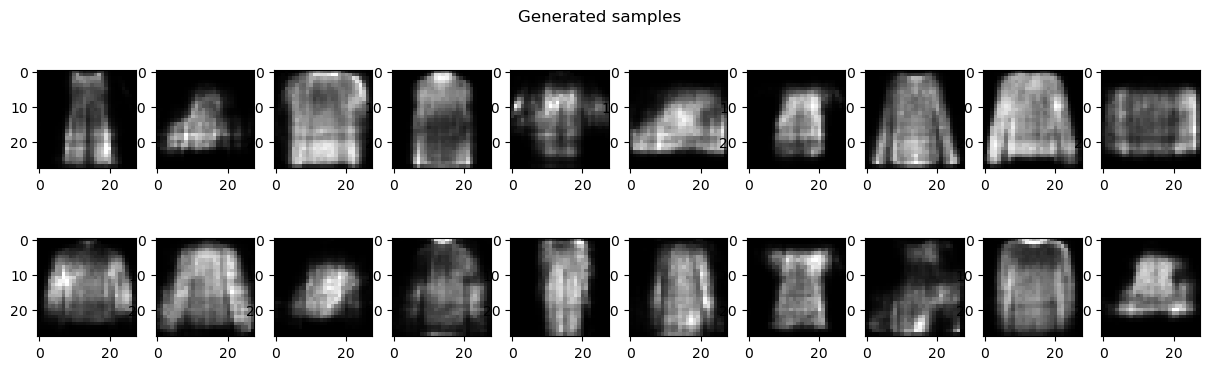

Epoch 22, Loss: 0.0116
Epoch 23, Loss: 0.0114
Epoch 24, Loss: 0.0113
Epoch 25, Loss: 0.0112
Epoch 26, Loss: 0.0110
Epoch 27, Loss: 0.0109
Epoch 28, Loss: 0.0107
Epoch 29, Loss: 0.0106
Epoch 30, Loss: 0.0105
Epoch 31, Loss: 0.0104


<Figure size 640x480 with 0 Axes>

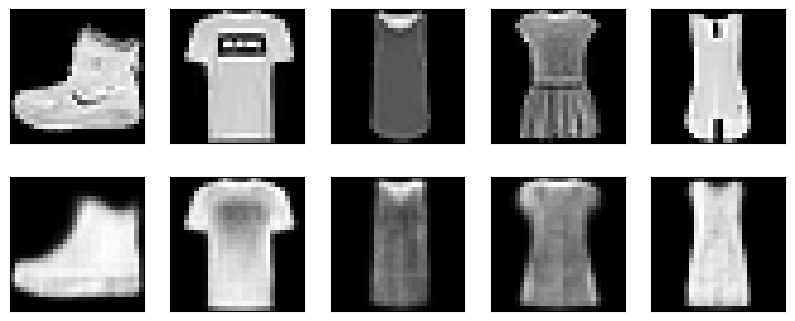

<Figure size 640x480 with 0 Axes>

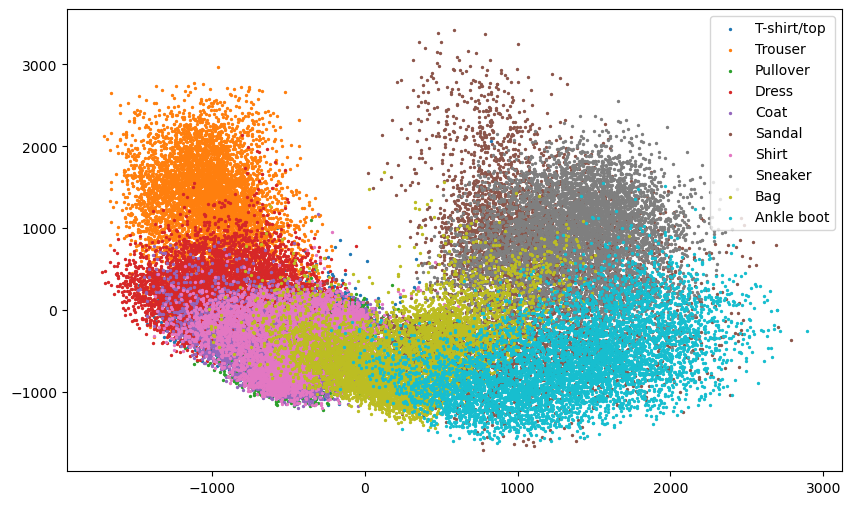

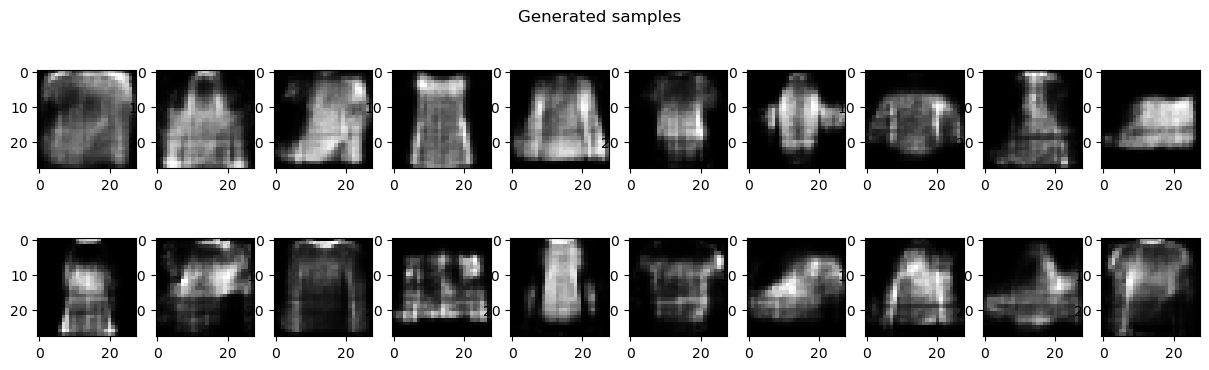

Epoch 32, Loss: 0.0102
Epoch 33, Loss: 0.0101
Epoch 34, Loss: 0.0100
Epoch 35, Loss: 0.0099
Epoch 36, Loss: 0.0098
Epoch 37, Loss: 0.0097
Epoch 38, Loss: 0.0097
Epoch 39, Loss: 0.0096
Epoch 40, Loss: 0.0095
Epoch 41, Loss: 0.0094


<Figure size 640x480 with 0 Axes>

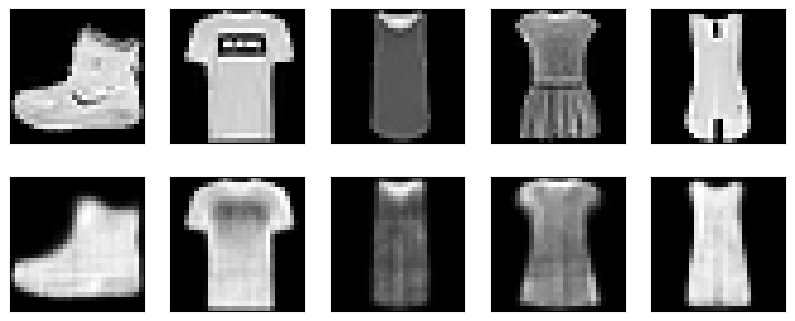

<Figure size 640x480 with 0 Axes>

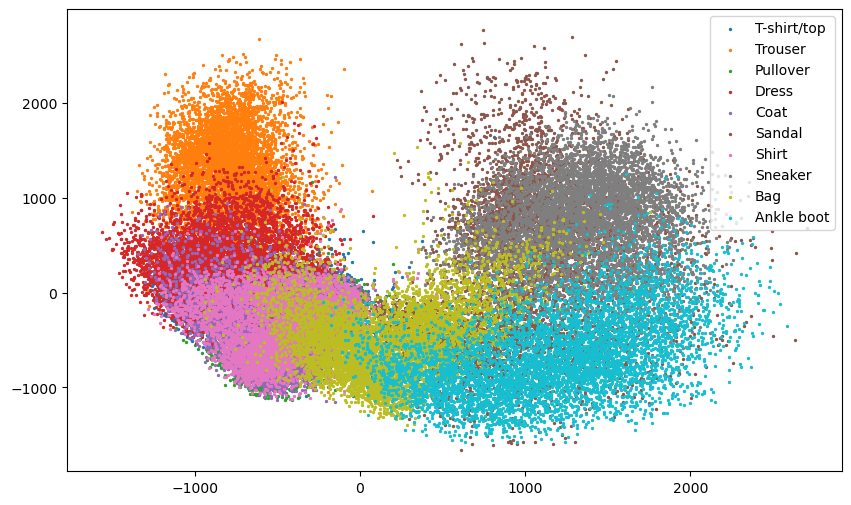

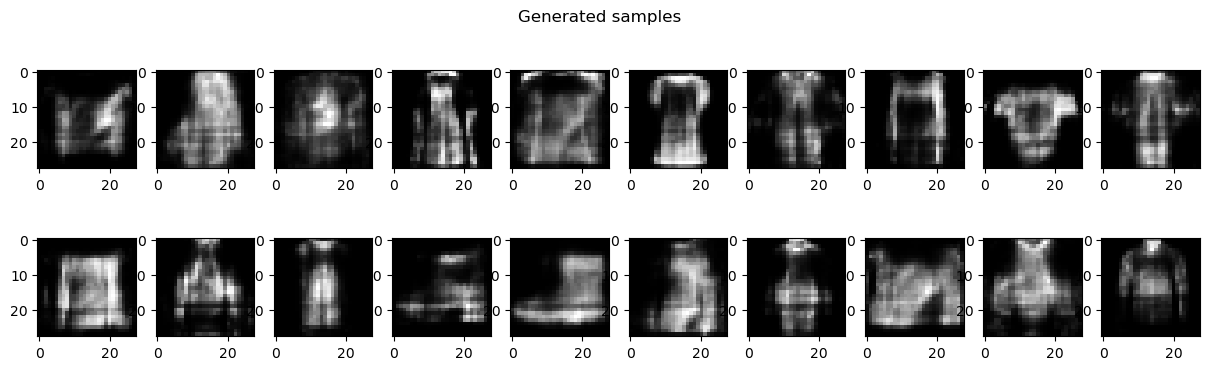

Epoch 42, Loss: 0.0093
Epoch 43, Loss: 0.0093
Epoch 44, Loss: 0.0092
Epoch 45, Loss: 0.0091
Epoch 46, Loss: 0.0091
Epoch 47, Loss: 0.0090
Epoch 48, Loss: 0.0090
Epoch 49, Loss: 0.0089
Epoch 50, Loss: 0.0088


In [20]:
device = torch.device('cpu')

def plot_samples(model):
    device = next(model.parameters()).device
    sampled_z = torch.randn(20, model.latent_dim).to(device)
    generated = model.decode(sampled_z)

    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

latent_dim = 50
sigma = 2 * latent_dim 
C = 1.0
epochs = 50
LR = 1e-3

wae = WAEMMD(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(wae.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    wae.train()
    epoch_losses = []
    for x, _ in train_loader:
        x = x.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        encoded, decoded = wae(x)
        rec_loss = rec_loss_fn(decoded, x)
        mmd_loss = wae.mmd_loss(encoded, sigma)
        loss = rec_loss + C * mmd_loss
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {np.mean(epoch_losses):.4f}')
    
    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)

## Więcej materiałów o modelach generatywnych

* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
